# Distance Metrics

This tutorial introduces the concept of **distance** between two bags of words or distributions, and demonstrates how to calculate this distance using gensim.

If you simply want to calculate the similarity between documents, then you may want to check out the [Similarity Queries Tutorial](https://radimrehurek.com/gensim/tut3.html) and the [API reference](https://radimrehurek.com/gensim/similarities/docsim.html). The current tutorial shows the building block of these larger methods, which are a small suite of distance metrics, including:

Here's a brief summary of this tutorial:

1. Set up a small corpus consisting of documents belonging to one of two topics
2. Train an LDA model to distinguish between the two topics
3. Use the model to obtain distributions for some sample words
4. Compare the distributions to each other using a variety of distance metrics:
 - Hellinger
 - Kullback-Leibler
 - Jaccard
5. Discuss the concept of distance metrics in slightly more detail

In [1]:
import logging
logging.basicConfig(level=logging.INFO)

In [2]:
from gensim.corpora import Dictionary

# you can use any corpus, this is just illustratory
texts = [
    ['bank','river','shore','water'],
    ['river','water','flow','fast','tree'],
    ['bank','water','fall','flow'],
    ['bank','bank','water','rain','river'],
    ['river','water','mud','tree'],
    ['money','transaction','bank','finance'],
    ['bank','borrow','money'], 
    ['bank','finance'],
    ['finance','money','sell','bank'],
    ['borrow','sell'],
    ['bank','loan','sell'],
]

dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

INFO:gensim.summarization.textcleaner:'pattern' package not found; tag filters are not available for English
INFO:gensim.corpora.dictionary:adding document #0 to Dictionary(0 unique tokens: [])
INFO:gensim.corpora.dictionary:built Dictionary(16 unique tokens: ['bank', 'river', 'shore', 'water', 'fast']...) from 11 documents (total 40 corpus positions)


In [3]:
import numpy
numpy.random.seed(1) # setting random seed to get the same results each time.

from gensim.models import ldamodel
model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=2, minimum_probability=1e-8)
model.show_topics()

INFO:gensim.models.ldamodel:using symmetric alpha at 0.5
INFO:gensim.models.ldamodel:using symmetric eta at 0.5
INFO:gensim.models.ldamodel:using serial LDA version on this node
INFO:gensim.models.ldamodel:running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 11 documents, updating model once every 11 documents, evaluating perplexity every 11 documents, iterating 50x with a convergence threshold of 0.001000
INFO:gensim.models.ldamodel:-3.572 per-word bound, 11.9 perplexity estimate based on a held-out corpus of 11 documents with 40 words
INFO:gensim.models.ldamodel:PROGRESS: pass 0, at document #11/11
INFO:gensim.models.ldamodel:topic #0 (0.500): 0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"
INFO:gensim.models.ldamodel:topic #1 (0.500): 0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"tran

[(0,
  '0.207*"bank" + 0.100*"water" + 0.089*"river" + 0.088*"sell" + 0.067*"borrow" + 0.064*"finance" + 0.062*"money" + 0.053*"tree" + 0.045*"flow" + 0.044*"rain"'),
 (1,
  '0.142*"bank" + 0.116*"water" + 0.090*"river" + 0.084*"money" + 0.081*"finance" + 0.064*"flow" + 0.055*"transaction" + 0.055*"tree" + 0.053*"fall" + 0.050*"mud"')]

Let's call the 1st topic the **water** topic and the second topic the **finance** topic.

Let's take a few sample documents and get them ready to test our distance functions.

In [4]:
doc_water = ['river', 'water', 'shore']
doc_finance = ['finance', 'money', 'sell']
doc_bank = ['finance', 'bank', 'tree', 'water']

# now let's make these into a bag of words format
bow_water = model.id2word.doc2bow(doc_water)   
bow_finance = model.id2word.doc2bow(doc_finance)   
bow_bank = model.id2word.doc2bow(doc_bank)   

# we can now get the LDA topic distributions for these
lda_bow_water = model[bow_water]
lda_bow_finance = model[bow_finance]
lda_bow_bank = model[bow_bank]

## Hellinger

We're now ready to apply our distance metrics.  These metrics return a value between 0 and 1, where values closer to 0 indicate a smaller 'distance' and therefore a larger similarity.

Let's start with the popular Hellinger distance. 
The Hellinger distance metric gives an output in the range [0,1] for two probability distributions, with values closer to 0 meaning they are more similar.

In [5]:
from gensim.matutils import hellinger

hellinger(lda_bow_water, lda_bow_finance)

0.24622736579004378

In [6]:
hellinger(lda_bow_finance, lda_bow_bank)

0.0073329423962157055

Makes sense, right? In the first example, Document 1 and Document 2 are hardly similar, so we get a value of roughly 0.5. 

In the second case, the documents are a lot more similar, semantically. Trained with the model, they give a much less distance value.

## Kullback–Leibler

Let's run similar examples down with Kullback Leibler.

In [7]:
from gensim.matutils import kullback_leibler

kullback_leibler(lda_bow_water, lda_bow_bank)

0.22783141

In [8]:
kullback_leibler(lda_bow_finance, lda_bow_bank)

0.00021458045

**NOTE!**

KL is not a Distance Metric in the mathematical sense, and hence is not symmetrical. 
This means that `kullback_leibler(lda_bow_finance, lda_bow_bank)` is not equal to  `kullback_leibler(lda_bow_bank, lda_bow_finance)`. 

In [9]:
# As you can see, the values are not equal. We'll get more into the details of this later on in the notebook.
kullback_leibler(lda_bow_bank, lda_bow_finance)

0.00021560304

In our previous examples we saw that there were lower distance values between bank and finance than for bank and water, even if it wasn't by a huge margin. What does this mean?

The `bank` document is a combination of both water and finance related terms - but as bank in this context is likely to belong to the finance topic, the distance values are less between the finance and bank bows.

In [10]:
# just to confirm our suspicion that the bank bow is more to do with finance:
model.get_document_topics(bow_bank)

[(0, 0.6412682), (1, 0.35873184)]

It's evident that while it isn't too skewed, it it more towards the finance topic.

Distance metrics (also referred to as similarity metrics), as suggested in the examples above, are mainly for probability distributions, but the methods can accept a bunch of formats for input. You can do some further reading on [Kullback Leibler](https://en.wikipedia.org/wiki/Kullback–Leibler_divergence) and [Hellinger](https://en.wikipedia.org/wiki/Hellinger_distance) to figure out what suits your needs.

## Jaccard 

Let us now look at the [Jaccard Distance](https://en.wikipedia.org/wiki/Jaccard_index) metric for similarity between bags of words (i.e, documents)

In [11]:
from gensim.matutils import jaccard

jaccard(bow_water, bow_bank)

0.8571428571428572

In [12]:
jaccard(doc_water, doc_bank)

0.8333333333333334

In [13]:
jaccard(['word'], ['word'])

0.0

The three examples above feature 2 different input methods. 

In the first case, we present to jaccard document vectors already in bag of words format. The distance can be defined as 1 minus the size of the intersection upon the size of the union of the vectors. 

We can see (on manual inspection as well), that the distance is likely to be high - and it is. 

The last two examples illustrate the ability for jaccard to accept even lists (i.e, documents) as inputs.
In the last case, because they are the same vectors, the value returned is 0 - this means the distance is 0 and they are very similar. 

## Distance Metrics for Topic Distributions

While there are already standard methods to identify similarity of documents, our distance metrics has one more interesting use-case: topic distributions. 

Let's say we want to find out how similar our two topics are, water and finance.

In [14]:
topic_water, topic_finance = model.show_topics()

# some pre processing to get the topics in a format acceptable to our distance metrics

def parse_topic_string(topic):
    # takes the string returned by model.show_topics()
    # split on strings to get topics and the probabilities
    topic = topic.split('+')
    # list to store topic bows
    topic_bow = []
    for word in topic:
        # split probability and word
        prob, word = word.split('*')
        # get rid of spaces and quote marks
        word = word.replace(" ","").replace('"', '')
        # convert to word_type
        word = model.id2word.doc2bow([word])[0][0]
        topic_bow.append((word, float(prob)))
    return topic_bow

finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# the finance topic in bag of words format looks like this:
finance_distribution

[(0, 0.142),
 (3, 0.116),
 (1, 0.09),
 (11, 0.084),
 (10, 0.081),
 (5, 0.064),
 (12, 0.055),
 (6, 0.055),
 (7, 0.053),
 (9, 0.05)]

Now that we've got our topics in a format more acceptable by our functions, let's use a Distance metric to see how similar the word distributions in the topics are.

In [15]:
hellinger(water_distribution, finance_distribution)

0.42898539619904935

Our value of roughly 0.36 means that the topics are not TOO distant with respect to their word distributions.
This makes sense again, because of overlapping words like `bank` and a small size dictionary.

## Kullback-Leibler Gotchas

In our previous example we didn't use Kullback Leibler to test for similarity for a reason - KL is not a Distance 'Metric' in the technical sense (you can see what a metric is [here](https://en.wikipedia.org/wiki/Metric_(mathematics)). The nature of it, mathematically also means we must be a little careful before using it, because since it involves the log function, a zero can mess things up. For example:

In [16]:
# 16 here is the number of features the probability distribution draws from
kullback_leibler(water_distribution, finance_distribution, 16) 

inf

That wasn't very helpful, right? This just means that we have to be a bit careful about our inputs. Our old example didn't work out because they were some missing values for some words (because `show_topics()` only returned the top 10 topics). 

This can be remedied, though.

In [17]:
# return ALL the words in the dictionary for the topic-word distribution.
topic_water, topic_finance = model.show_topics(num_words=len(model.id2word))

# do our bag of words transformation again
finance_distribution = parse_topic_string(topic_finance[1])
water_distribution = parse_topic_string(topic_water[1])

# and voila!
kullback_leibler(water_distribution, finance_distribution)

0.087688535

You may notice that the distance for this is quite less, indicating a high similarity. This may be a bit off because of the small size of the corpus, where all topics are likely to contain a decent overlap of word probabilities. You will likely get a better value for a bigger corpus.

So, just remember, if you intend to use KL as a metric to measure similarity or distance between two distributions, avoid zeros by returning the ENTIRE distribution. Since it's unlikely any probability distribution will ever have absolute zeros for any feature/word, returning all the values like we did will make you good to go.

## What are Distance Metrics? 

Having seen the practical usages of these measures (i.e, to find similarity), let's learn a little about what exactly Distance Measures and Metrics are. 

I mentioned in the previous section that KL was not a distance metric. There are 4 conditons for for a distance measure to be a matric:

1.	d(x,y) >= 0
2.  d(x,y) = 0 <=> x = y
3.  d(x,y) = d(y,x)
4.  d(x,z) <= d(x,y) + d(y,z)

That is: it must be non-negative; if x and y are the same, distance must be zero; it must be symmetric; and it must obey the triangle inequality law. 

Simple enough, right? 
Let's test these out for our measures.

In [18]:
# normal Hellinger
a = hellinger(water_distribution, finance_distribution)
a

0.14950162744749795

In [19]:
# we swap finance and water distributions and get the same value. It is indeed symmetric!
b = hellinger(finance_distribution, water_distribution)
b

0.14950162744749795

In [20]:
a == b

True

In [21]:
# if we pass the same values, it is zero.
hellinger(water_distribution, water_distribution)

0.0

In [22]:
# for triangle inequality let's use LDA document distributions
hellinger(lda_bow_finance, lda_bow_bank)

0.0073329423962157055

In [23]:
# Triangle inequality works too!
hellinger(lda_bow_finance, lda_bow_water) + hellinger(lda_bow_water, lda_bow_bank)

0.4852304816311588

So Hellinger is indeed a metric. Let's check out KL. 

In [24]:
a = kullback_leibler(finance_distribution, water_distribution)
a

0.09273797

In [25]:
b = kullback_leibler(water_distribution, finance_distribution)
b

0.087688535

In [26]:
a == b

False

We immediately notice that when we swap the values they aren't equal! One of the four conditions not fitting is enough for it to not be a metric. 

However, just because it is not a metric, (strictly in the mathematical sense) does not mean that it is not useful to figure out the distance between two probability distributions. KL Divergence is widely used for this purpose, and is probably the most 'famous' distance measure in fields like Information Theory.

For a nice review of the mathematical differences between Hellinger and KL, [this](http://stats.stackexchange.com/questions/130432/differences-between-bhattacharyya-distance-and-kl-divergence) link does a very good job. 

# Visualizing Distance Metrics

Let's plot a graph of our toy dataset using the popular [networkx](https://networkx.github.io/documentation/stable/) library. 

Each node will be a document, where the color of the node will be its topic according to the LDA model. Edges will connect documents to each other, where the _weight_ of the edge will be inversely proportional to the Jaccard similarity between two documents. We will also annotate the edges to further aid visualization: **strong** edges will connect similar documents, and **weak (dashed)** edges will connect dissimilar documents.

In summary, similar documents will be closer together, different documents will be further apart.

In [27]:
def get_most_likely_topic(doc):
    bow = model.id2word.doc2bow(doc)
    topics, probabilities = zip(*model.get_document_topics(bow))
    max_p = max(probabilities)
    topic = topics[probabilities.index(max_p)]
    return topic

def get_node_color(i):
    return 'skyblue' if get_most_likely_topic(texts[i]) == 0 else 'pink'

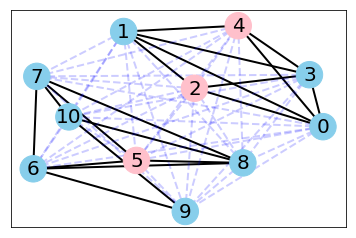

In [28]:
%matplotlib inline
import itertools
import networkx as nx

G = nx.Graph()
for i, _ in enumerate(texts):
    G.add_node(i)
    
for (i1, i2) in itertools.combinations(range(len(texts)), 2):
    bow1, bow2 = texts[i1], texts[i2]
    distance = jaccard(bow1, bow2)
    G.add_edge(i1, i2, weight=1/distance)
    
#
# https://networkx.github.io/documentation/networkx-1.9/examples/drawing/weighted_graph.html
#
pos = nx.spring_layout(G)

threshold = 1.25
elarge=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] > threshold]
esmall=[(u,v) for (u,v,d) in G.edges(data=True) if d['weight'] <= threshold]

node_colors = [get_node_color(i) for (i, _) in enumerate(texts)]
nx.draw_networkx_nodes(G, pos, node_size=700, node_color=node_colors)
nx.draw_networkx_edges(G,pos,edgelist=elarge, width=2)
nx.draw_networkx_edges(G,pos,edgelist=esmall, width=2, alpha=0.2, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=20, font_family='sans-serif');

In [29]:
for i, t in enumerate(texts):
    print(i, get_most_likely_topic(t), t)

0 0 ['bank', 'river', 'shore', 'water']
1 0 ['river', 'water', 'flow', 'fast', 'tree']
2 1 ['bank', 'water', 'fall', 'flow']
3 0 ['bank', 'bank', 'water', 'rain', 'river']
4 1 ['river', 'water', 'mud', 'tree']
5 1 ['money', 'transaction', 'bank', 'finance']
6 0 ['bank', 'borrow', 'money']
7 0 ['bank', 'finance']
8 0 ['finance', 'money', 'sell', 'bank']
9 0 ['borrow', 'sell']
10 0 ['bank', 'loan', 'sell']


## Conclusion

That brings us to the end of this small tutorial.
The scope for adding new similarity metrics is large, as there exist an even larger suite of metrics and methods to add to the matutils.py file. ([This](http://nzcsrsc08.canterbury.ac.nz/site/proceedings/Individual_Papers/pg049_Similarity_Measures_for_Text_Document_Clustering.pdf) is one paper which talks about some of them)